In [13]:
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Set random seed for reproducibility
torch.manual_seed(42)

# Data Transformation
trans = transforms.ToTensor()

# Download and load FashionMNIST dataset
mnist_train = torchvision.datasets.FashionMNIST(root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(root="../data", train=False, transform=trans, download=True)

# DataLoader
train_iter = data.DataLoader(mnist_train, batch_size=1000, shuffle=True)
test_iter = data.DataLoader(mnist_test, batch_size=1000, shuffle=False)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [15]:
class SoftMaxClassifier(nn.Module):
    def __init__(self, num_features,num_outputs):
        
        super().__init__()
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_features,num_outputs)
        )
    
    def forward(self,X):
        return self.network(X)

    def predict(self, X):
        # Forward pass and return predicted class
        probs = self.forward(X)
        return torch.argmax(probs, dim=1)

In [16]:
# Evaluation
def evaluate_accuracy(model, data_iter):
    correct_predictions = 0
    total_samples = 0
    
    with torch.no_grad():
        for X, y in data_iter:
            X,y = X.to(device), y.to(device)
            y_pred = model.predict(X)
            correct_predictions += (y_pred == y).sum().item()
            total_samples += y.size(0)
    
    return correct_predictions / total_samples

In [17]:
## Important parameter
num_inputs = 784
num_outputs = 10
loss_func = nn.CrossEntropyLoss()

In [18]:
lr = 0.1
epochs = 15

In [19]:
model = SoftMaxClassifier(num_inputs,num_outputs)
model.to(device)
optimizer = torch.optim.SGD(model.parameters(),lr= lr)

In [20]:
# Train 
def train_loop(train_iter,model,optimizer,loss_func):
    train_total = 0
    train_correct = 0
    for X,y in train_iter:
        X,y = X.to(device), y.to(device)
        
        # forward pass
        y_pred = model.forward(X)
        
        # calculate loss
        loss = loss_func(y_pred,y)
        
        # clear gradients
        optimizer.zero_grad()

        # backward pass
        loss.backward()
        
        # update params
        optimizer.step()

        # calculate train acc
        _, predicted = torch.max(y_pred, 1)  # Get the predicted class
        train_total += y.size(0)  # Total number of samples
        train_correct += (predicted == y).sum().item()  # Correct predictions

    # Calculate metrics
    train_loss = torch.Tensor.item(loss.mean())
    train_acc = train_correct / train_total
    
    return train_loss, train_acc

In [21]:
# Train Function
def train_model(train_iter, test_iter,model,optimizer,loss_func,epochs):
    train_loss = []
    train_acc = []
    test_accuracy = []
    for epoch in range(0,epochs):
        train_metrics = train_loop(train_iter,model,optimizer,loss_func)
        test_acc = evaluate_accuracy(model,train_iter)
        train_loss.append(train_metrics[0])
        train_acc.append(train_metrics[1])
        test_accuracy.append(test_acc)
        # print loss in each epoch
        print(f'Epoch: {epoch + 1}, Loss: {train_metrics[0]}, Train Accuracy: {train_metrics[1]}, Test Accuracy: {test_acc}')
    
    return train_loss, train_acc, test_accuracy
        

In [22]:
# Train model
metrics = train_model(train_iter,test_iter, model, optimizer, loss_func, epochs)

Epoch: 1, Loss: 0.7640246152877808, Train Accuracy: 0.6679333333333334, Test Accuracy: 0.7462833333333333
Epoch: 2, Loss: 0.7137670516967773, Train Accuracy: 0.7669, Test Accuracy: 0.78495
Epoch: 3, Loss: 0.646286129951477, Train Accuracy: 0.7909166666666667, Test Accuracy: 0.7980666666666667
Epoch: 4, Loss: 0.6156026124954224, Train Accuracy: 0.8025333333333333, Test Accuracy: 0.8062
Epoch: 5, Loss: 0.5676910281181335, Train Accuracy: 0.8100333333333334, Test Accuracy: 0.8133333333333334
Epoch: 6, Loss: 0.5666754841804504, Train Accuracy: 0.8150166666666666, Test Accuracy: 0.8185
Epoch: 7, Loss: 0.5092136263847351, Train Accuracy: 0.82015, Test Accuracy: 0.8233666666666667
Epoch: 8, Loss: 0.5486487746238708, Train Accuracy: 0.82315, Test Accuracy: 0.8235833333333333
Epoch: 9, Loss: 0.5003964304924011, Train Accuracy: 0.8253333333333334, Test Accuracy: 0.8273333333333334
Epoch: 10, Loss: 0.4809359312057495, Train Accuracy: 0.8273166666666667, Test Accuracy: 0.8291
Epoch: 11, Loss: 0.56

In [23]:
import seaborn as sns

def plot_graph(metrics):
    sns.lineplot(metrics[0], label = "Train Loss")
    sns.lineplot(metrics[1], label = "Train Accuracy")
    sns.lineplot(metrics[2], label = "Test Accuracy")
    plt.show()

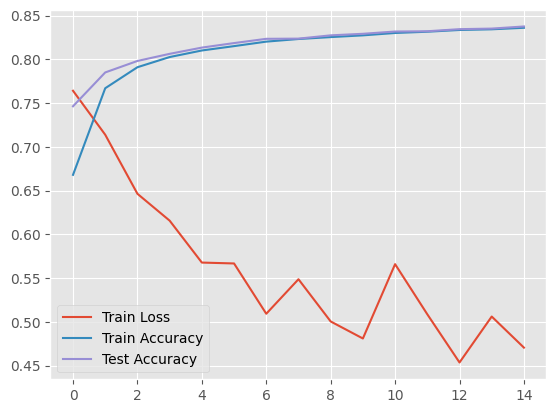

In [24]:
plot_graph(metrics)